In [146]:
# import os
# os.chdir('../')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import multipy

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, \
                            plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence
from utils.weblogo_utils import create_web_logo
from math import sqrt


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.clustering_utils")
importlib.reload(imported_module)

<module 'utils.clustering_utils' from '/home/ekvlasova/tcr-covid-classifier/utils/clustering_utils.py'>

In [71]:
# os.chdir('ekvlasova/tcr-covid-classifier')

In [21]:
old_beta = pd.read_csv('notebooks/old_beta.csv').drop(columns=['Unnamed: 0']).rename(columns={'0': 'cdr3aa'})

In [22]:
old_beta

,cdr3aa
0,CASSLGYEQYF
1,CASSLGGNQPQHF
2,CASSLGSNQPQHF
3,CASSLTGNTEAFF
4,CASSSSYEQYF
...,...
305,CASSQKGYEQYF
306,CASSMDRGYEQYF
307,CASRRTYEQYF
308,CASSRGWEQYF


In [6]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [7]:
beta_pvals = pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_top_500k.csv').drop(columns=['Unnamed: 0'])

<AxesSubplot:>

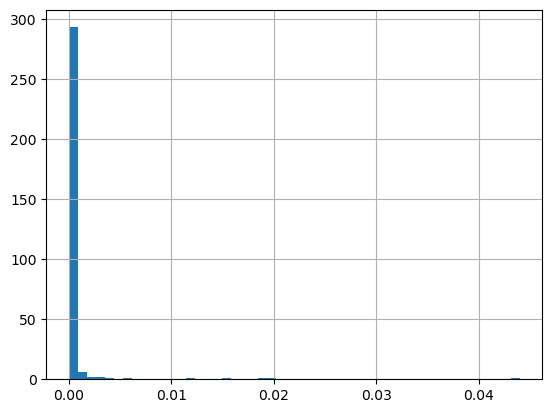

In [27]:
beta_pvals[beta_pvals.clone.isin(old_beta.cdr3aa)].pval.hist(bins=50)

In [32]:
beta_pvals[(beta_pvals.clone.isin(old_beta.cdr3aa)) & (beta_pvals.pval < 1e-6)]

,clone,pval
90342,CASRQGYEQYF,3.405890e-09
111746,CASSADSYEQYF,4.839813e-10
116864,CASSAGTGSYEQYF,3.493633e-07
117784,CASSAGYEQYF,7.873694e-09
126444,CASSASYEQYF,1.409516e-08
...,...,...
752689,CASSYDSYEQYF,1.915344e-11
756255,CASSYGGSYEQYF,1.383528e-08
759602,CASSYGTGSYEQYF,9.798225e-08
760382,CASSYGYEQYF,1.144189e-09


In [33]:
beta_pvals[beta_pvals.pval < 1e-6]

,clone,pval
17813,CASARGYEQYF,4.799746e-07
25268,CASGLGGSYEQYF,8.566854e-07
26190,CASGLSGGNQPQHF,6.003522e-09
90342,CASRQGYEQYF,3.405890e-09
102014,CASRTAYEQYF,7.223072e-08
...,...,...
897528,CSASDSYEQYF,2.970028e-07
898435,CSASGGGYEQYF,3.026567e-07
905190,CSASSGHEQYF,7.120231e-07
907031,CSATDLNTEAFF,5.898885e-07


In [200]:
from multipy.fdr import lsu

beta_pvals[lsu(beta_pvals.pval, q=0.01)]

,clone,pval
17813,CASARGYEQYF,4.799746e-07
18992,CASDRGYEQYF,1.689717e-06
25227,CASGLGGNQPQHF,1.088938e-06
25268,CASGLGGSYEQYF,8.566854e-07
26190,CASGLSGGNQPQHF,6.003522e-09
...,...,...
905760,CSASSSYEQYF,2.808909e-06
906007,CSASTGGYEQYF,2.892145e-06
907031,CSATDLNTEAFF,5.898885e-07
909744,CSATSGHEQYF,3.154380e-09


In [199]:
alpha_pvals[lsu(alpha_pvals.pval, q=0.01)]

,clone,pval
354,CAAADNFNKFYF,9.144445e-09
607,CAAAFNKFYF,5.057810e-07
1685,CAAALYNFNKFYF,2.540847e-13
1746,CAAANFNKFYF,3.867558e-24
1768,CAAANNFNKFYF,1.599906e-05
...,...,...
1134227,RALSEAQGGSEKLVF,4.900306e-06
1134429,RALSSGSARQLTF,3.889343e-06
1134542,RALYNFNKFYF,1.493361e-10
1142371,YAALYNFNKFYF,1.922726e-09


In [197]:
beta_pvals[lsu(beta_pvals.pval, q=0.01)][['clone']].to_csv('data/covid_significant_clones_fmba_TRB_top_500k.csv', index=False)

In [198]:
alpha_pvals[lsu(alpha_pvals.pval, q=0.01)][['clone']].to_csv('data/covid_significant_clones_fmba_TRA_top_500k.csv', index=False)

In [141]:
beta_pvals[beta_pvals.pval < 1e-4][['clone']].to_csv('data/covid_significant_clones_fmba_TRB_top_500k.csv', index=False)

In [189]:
res_beta = seqs2hamming(beta_pvals[lsu(beta_pvals.pval, q=0.01)].clone, viz_method='graphopt')

In [190]:
res_beta

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CASARGYEQYF,0,127.401975,7.844402,123,202.929423,-64.390319
1,CASDRGYEQYF,0,126.576943,-7.151173,123,202.929423,-64.390319
2,CASKRGYEQYF,0,116.578176,-17.857588,123,202.929423,-64.390319
3,CASMRGYEQYF,0,107.030719,-6.898679,123,202.929423,-64.390319
4,CASSRGYEQYF,0,181.811679,-45.923335,123,202.929423,-64.390319
...,...,...,...,...,...,...,...
531,CSASDRGYEQYF,58,-519.851252,321.511775,1,-519.851252,321.511775
532,CSASGGGYEQYF,59,537.858978,-50.494258,2,538.865482,-40.134884
533,CSASTGGYEQYF,59,539.871986,-29.775510,2,538.865482,-40.134884
534,CSATDLNTEAFF,60,381.116455,-470.310874,1,381.116455,-470.310874


In [183]:
beta_cluster_to_epi = {}
for cluster_index in range(res_beta.cluster.max()):
    beta_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_beta, cluster_index, dist=1, gene='TRB', alpha=0.05)

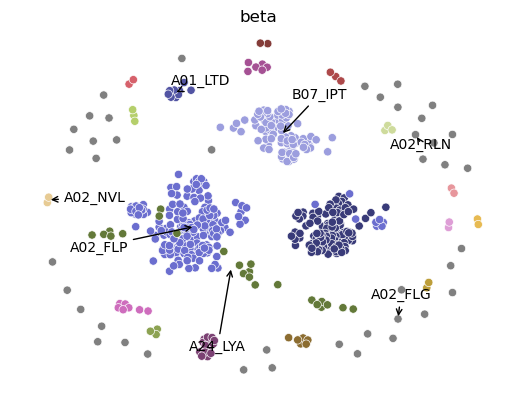

In [191]:
plot_clonotype_clustering_with_epitope_labeling(res_beta, 
                                                beta_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=450, 
                                                center_diff_threshold=75,
                                                )

plt.xlim(-700, 700)
plt.ylim(-700, 700)
plt.title('beta')
plt.legend().set_visible(False)

In [72]:
alpha_pvals = pd.read_csv('data/covid_significant_clone_pvals_fmba_TRA_top_500k.csv').drop(columns=['Unnamed: 0'])

In [73]:
alpha_pvals[alpha_pvals.pval < 1e-4]

,clone,pval
354,CAAADNFNKFYF,9.144445e-09
607,CAAAFNKFYF,5.057810e-07
1685,CAAALYNFNKFYF,2.540847e-13
1732,CAAANAGNNRKLIW,7.172378e-05
1746,CAAANFNKFYF,3.867558e-24
...,...,...
1134227,RALSEAQGGSEKLVF,4.900306e-06
1134429,RALSSGSARQLTF,3.889343e-06
1134542,RALYNFNKFYF,1.493361e-10
1142371,YAALYNFNKFYF,1.922726e-09


In [185]:
res_alpha = seqs2hamming(alpha_pvals[lsu(alpha_pvals.pval, q=0.01)].clone, viz_method='drl')

In [186]:
res_alpha

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAAADNFNKFYF,0,49.208729,89.142868,805,80.219823,47.230989
1,CAAANNFNKFYF,0,47.839878,91.348152,805,80.219823,47.230989
2,CAAAYNFNKFYF,0,126.998703,100.550354,805,80.219823,47.230989
3,CAAEDNFNKFYF,0,49.723202,87.962006,805,80.219823,47.230989
4,CAAGDNFNKFYF,0,49.311348,88.017265,805,80.219823,47.230989
...,...,...,...,...,...,...,...
4494,CVVSDLMEYGNKLVF,161,419.783569,8.844162,1,419.783569,8.844162
4495,CVVSELSGGYQKVTF,162,-225.751801,284.361938,2,-225.689201,284.620117
4496,CVVSEPSGGYQKVTF,162,-225.626602,284.878296,2,-225.689201,284.620117
4497,CVVSPASGTYKYIF,163,-413.982880,75.798058,1,-413.982880,75.798058


In [187]:
alpha_cluster_to_epi = {}
for cluster_index in range(res_alpha.cluster.max()):
    alpha_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_alpha, cluster_index, dist=1, gene='TRA', alpha=0.05)

NVILLNKHI
FKDNVILLN


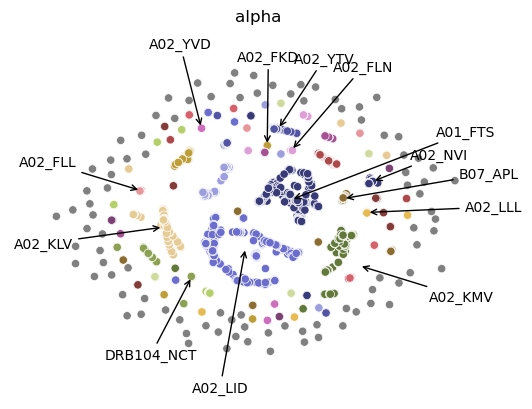

In [196]:
plot_clonotype_clustering_with_epitope_labeling(res_alpha, 
                                                alpha_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRA', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=500, 
                                                center_diff_threshold=75,
                                                )

plt.xlim(-600, 600)
plt.ylim(-600, 600)
plt.title('alpha')
plt.legend().set_visible(False)

In [192]:
for alpha_cluster in alpha_cluster_to_epi.keys():
    for beta_cluster in beta_cluster_to_epi.keys():
        if alpha_cluster_to_epi[alpha_cluster] is not None and beta_cluster_to_epi[beta_cluster] is not None and len(
            alpha_cluster_to_epi[alpha_cluster][['antigen.epitope']].merge(beta_cluster_to_epi[beta_cluster][['antigen.epitope']])) > 0:
            
            print(alpha_cluster, beta_cluster)
            print(alpha_cluster_to_epi[alpha_cluster][['antigen.epitope', 'antigen.species']].merge(
                beta_cluster_to_epi[beta_cluster][['antigen.epitope', 'antigen.species']]))

0 6
  antigen.epitope antigen.species
0       FTSDYYQLY      SARS-CoV-2
2 6
  antigen.epitope antigen.species
0   PKYVKQNTLKLAT      InfluenzaA
3 2
  antigen.epitope antigen.species
0       LLWNGPMAV             YFV
9 0
   antigen.epitope antigen.species
0  PGVLLKEFTVSGNIL     HomoSapiens
30 1
  antigen.epitope antigen.species
0       LTDEMIAQY      SARS-CoV-2
30 6
  antigen.epitope antigen.species
0       LTDEMIAQY      SARS-CoV-2
115 2
  antigen.epitope antigen.species
0       YVDNSSLTI      SARS-CoV-2
